## Version Information

<table align="left">
  <thead>
    <tr>
      <th>Component</th>
      <th>Version</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>python</td>
      <td>3.11.5</td>
    </tr>
    <tr>
      <td>cirq</td>
      <td>1.3.0</td>
    </tr>
  </tbody>
</table>

</table>


In [123]:
import cirq
import math
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

from sympy import isprime
import random
from fractions import Fraction


In [124]:
def find_all_as(N):
    ns=[]
    for n in range(2,N):
        if math.gcd(n,N)==1:
            ns.append(n)
    return ns

def validate_a(a):
    ns = find_all_as(N)
    if a not in ns:
        raise ValueError(f"'a' must be one of {ns}")
    return True

def get_nlen_mlen(N):       
    n_len = math.ceil(math.log2(N))
    m_len = 2 * n_len
    return n_len, m_len 

def is_power_of_prime(N):
    for base in range(2, int(math.sqrt(N)) + 1):
        power = 2
        while (result := base ** power) <= N:
            if result == N:
                return True
            power += 1
    return False

def validate_N(N):
    if isprime(N):
        raise ValueError(f"{N} is a prime.")
    if is_power_of_prime(N):
        raise ValueError(f"{N} is a power of a prime.")
    return True


def check_r_condition(a, r, N):
    if r % 2 == 0 and pow(a, r // 2, N) != N - 1:
        return True
    else:
        return False
    
    
# 100 of prime numbers
prime_100 = [2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97, 101, 103, 
             107, 109, 113, 127, 131, 137, 139, 149, 151, 157, 163, 167, 173, 179, 181, 191, 193, 197, 199, 211, 223, 
             227, 229, 233, 239, 241, 251, 257, 263, 269, 271, 277, 281, 283, 293, 307, 311, 313, 317, 331, 337, 347, 
             349, 353, 359, 367, 373, 379, 383, 389, 397, 401, 409, 419, 421, 431, 433, 439, 443, 449, 457, 461, 463, 
             467, 479, 487, 491, 499, 503, 509, 521, 523, 541]

def generate_N():
    ACCEPTED_N = False
    max_qubits = 29
    while not ACCEPTED_N:
        ps = random.sample(prime_100[5:], 2)
        N = ps[0]*ps[1]
        n_len, m_len = get_nlen_mlen(N)
        if n_len+m_len<=max_qubits:
            print(f"N = {ps[0]} * {ps[1]} = {N}")
            return N

In [173]:
def get_nlen_mlen(N):       
    n_len = math.ceil(math.log2(N))
    m_len = 2 * n_len
    return n_len, m_len 

def initiate_qc(N):
    # identify n-length and m-length
    n_len, m_len = get_nlen_mlen(N)
    
    # Create qubits
    counting_qubits = [cirq.LineQubit(i) for i in range(m_len)]
    auxiliary_qubits = [cirq.LineQubit(i + m_len) for i in range(n_len)]
    
    # Create a circuit
    qc = cirq.Circuit()
    
    # Initialize counting qubits in state |+>
    for qubit in counting_qubits:
        qc.append(cirq.H(qubit))

    # Initialize auxiliary qubits in state |1>
    qc.append(cirq.X(auxiliary_qubits[0]))
    
    qc.append(cirq.I.on_each(auxiliary_qubits[1:]))

    return qc

def append_c_amodN(qc, a, N):
    n_len, m_len = get_nlen_mlen(N)
    qubits = sorted(qc.all_qubits())
    counting_qubits = qubits[:m_len]
    auxiliary_qubits = qubits[m_len:]
    
    for q in range(m_len):
        pwr = 2**q
        for i, bit in enumerate(format(pow(a, pwr, N) ^ 1, f'0{n_len}b')):
            if bit == '1':
                qc.append(cirq.CX(counting_qubits[q], auxiliary_qubits[i]))
    
    return qc

def append_IQFT(qc, N):
    n_len, m_len = get_nlen_mlen(N)
    qubits = sorted(qc.all_qubits())
    counting_qubits = qubits[:m_len]
    
    qc.append(cirq.inverse(cirq.qft(*counting_qubits)))
    return qc

def print_c_amodN(a, N):
    n_len, m_len = get_nlen_mlen(N)
    
    for p in range(m_len):
        pwr = 2**p
        _txt = f'a={a}, N={N}, p={p}, 2^p=pwr={pwr}'
        print(f"\n{_txt}\n{len(_txt)*'-'}")
    
        print(f"{format(pow(a,pwr,N), f'0{n_len}b')} | {a}^{pwr} mod {N} = {pow(a,pwr,N)}")
        print(f"{format(pow(a,pwr,N)^1, f'0{n_len}b')} | x_gates")
        
        
def append_measurements(qc):
    n_len, m_len = get_nlen_mlen(N)
    qubits = sorted(qc.all_qubits())
    counting_qubits = qubits[:m_len]
    
    qc.append(cirq.measure(*counting_qubits, key='result'))
    return qc

def simulation(qc, N, shots=1000):
    _, m_len = get_nlen_mlen(N)
    # Create a simulator
    simulator = cirq.Simulator()
    
    # Simulate the circuit
    result = simulator.run(qc, repetitions=shots)
    
    # Get the measurement results
    counts = result.histogram(key='result')
    
    # Convert to a list of unique results
    unique_results = list(counts.keys())
    
    return [format(v, f'0{m_len}b')[::-1] for v in unique_results]

def shor_qc(a, N, display=False, shots=1):
    _, m_len = get_nlen_mlen(N)
    
    qc = initiate_qc(N)
    qc = append_c_amodN(qc, a, N)
    qc = append_IQFT(qc, N)
    qc = append_measurements(qc)
    
    if display:
        print(qc)
        display(SVGCircuit(qc))
    
    return simulation(qc, N, shots=shots)

               ┌──┐
0: ────H───@────@─────────qft^-1───M('result')───
           │    │         │        │
1: ────H───┼────┼@────@───#2───────M─────────────
           │    ││    │   │        │
2: ────H───┼────┼┼────┼───#3───────M─────────────
           │    ││    │   │        │
3: ────H───┼────┼┼────┼───#4───────M─────────────
           │    ││    │   │        │
4: ────H───┼────┼┼────┼───#5───────M─────────────
           │    ││    │   │        │
5: ────H───┼────┼┼────┼───#6───────M─────────────
           │    ││    │   │        │
6: ────H───┼────┼┼────┼───#7───────M─────────────
           │    ││    │   │        │
7: ────H───┼────┼┼────┼───#8───────M─────────────
           │    ││    │
8: ────X───┼────┼┼────┼──────────────────────────
           │    ││    │
9: ────I───X────┼X────┼──────────────────────────
                │     │
10: ───I────────X─────┼──────────────────────────
                      │
11: ───I──────────────X──────────────────────────
               └──┘


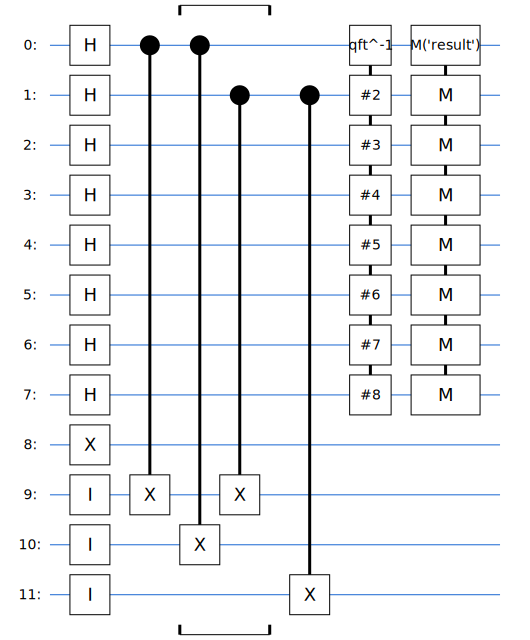

['01000000', '10000000', '00000000', '11111111', '01111111', '10100000', '01110111', '11000000', '10010000', '01010000', '11100111', '10001111', '01110000', '10111111', '01111000', '01011011', '01011111', '01100000', '11011111', '11101111', '11100000', '11011100', '10101111', '10001000', '10010111', '10110000', '11110001', '01101000', '10011111', '11010000', '11110111', '01101111', '11110000', '01010011', '10000111', '01111011', '11001111']


In [174]:
# Example usage
N = 15  # Example value
a = 7  # Example value


qc = initiate_qc(N)
qc = append_c_amodN(qc, a, N)
qc = append_IQFT(qc, N)
qc = append_measurements(qc)

print(qc)
display(SVGCircuit(qc))
print(simulation(qc, N))


In [176]:
FACTOR_FOUND = False
ATTEMPT = 0

N =generate_N()


# validate_N(N)  # no need to validate N value

n_len, m_len = get_nlen_mlen(N)

while not FACTOR_FOUND:
    ATTEMPT = 0
    for a in range(2,N):
        if math.gcd(a,N)==1:
            ATTEMPT += 1
            _txt = f'\n[a = {a}]'
            print(f"{_txt}\n{'-'*len(_txt)}")
            print(f"ATTEMPT {ATTEMPT}:")
            
            readings = shor_qc(a, N)
            print(readings)
            for reading in readings:
                print(f"\nRegister Reading: {reading} [{int(reading,2)}]")
                phase = int(reading,2)/(2**m_len)
                frac = Fraction(phase).limit_denominator(N)
                r = frac.denominator
                print(f"Corresponding Phase: [{int(reading,2)}/{(2**m_len)}] >>> {phase:0.5f} >>> {frac}")
                
                print(f"Result: r = {r}")

                if not check_r_condition(a, r, N):
                    print(f"[{r}] did not pass r conditions")
                    continue

                if phase != 0:
                    # Guesses for factors are gcd(x^{r/2} ±1 , 15)
                    guesses = [math.gcd(a**(r//2)-1, N), math.gcd(a**(r//2)+1, N)]
                    print(f"Guessed Factors: {guesses[0]} and {guesses[1]}")
                    for guess in guesses:
                        if guess not in [1,N] and (N % guess) == 0:
                            # Guess is a factor!
                            print(f"*** Non-trivial factor found: {guess} ***")
                            FACTOR_FOUND = True
                            
                if FACTOR_FOUND:
                    break

        else:
            print(f'\n# [a={a}] is not an accepted value! #')
            
        if FACTOR_FOUND:
            break
    
    if not FACTOR_FOUND:
        print('\nALL VALID A VALUES ARE USED !')
        FACTOR_FOUND = True

N = 31 * 13 = 403

[a = 2]
--------
ATTEMPT 1:
['100101100110011110']

Register Reading: 100101100110011110 [154014]
Corresponding Phase: [154014/262144] >>> 0.58752 >>> 47/80
Result: r = 80
Guessed Factors: 31 and 1
*** Non-trivial factor found: 31 ***
